In [33]:
import numpy as np
import pandas as pd
%matplotlib inline

In [34]:
""" Module to compute projections on the positive simplex or the L1-ball
A positive simplex is a set X = { \mathbf{x} | \sum_i x_i = s, x_i \geq 0 }
The (unit) L1-ball is the set X = { \mathbf{x} | || x ||_1 \leq 1 }
Adrien Gaidon - INRIA - 2011
"""


import numpy as np


def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1] 
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / (rho+1)    ## modified
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w


def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w



# 1

In [35]:
n=500
M1 = 1
M2 = n**(1/2)
z = np.random.binomial(1,0.5,size = n*n).reshape(n,n)
z = 2*z-1

In [36]:
def SubGD(z,x):
    zi = z[np.argmax(z.dot(x))]
    return zi

In [37]:
def f(x):
    return np.max(z.dot(x))

In [38]:
def MirrorDescent(z,n,M,K):
    x = [1/n*np.ones(n)]
    a = [0]
    i = 1
    x_old = x[-1]
    f_query = [f(x_old)]
    f_ave = [f(x_old)]
    while i <= K:
        ai = 1/M/(i**(1/2))
        a.append(ai)
        
        gx = SubGD(z,x_old)
        x_new = x_old*np.exp(-ai*gx + ai*np.min(gx) )
        x_new = euclidean_proj_simplex(x_new, s = 1)
        x.append(x_new)
        x_old = x_new
        i += 1
        f_query.append(f(x_new))
        x_outk = sum([a_item*x_item for a_item,x_item in zip(a,x)])/sum(a)
        f_ave.append(f(x_outk))
        
    x_k = x[-1]
    x_out = sum([i*j for i,j in zip(a,x)])/sum(a)
    return x_k, x_out, f_query, f_ave

#### Projected GD:
def ProGD(z,n,M,K):  #   eta is the stepsize
    x = [1/n*np.ones(n)]
    i = 1
    a = [0]
    x_old = x[-1]
    f_query = [f(x_old)]
    f_ave = [f(x_old)]
    while i <= K:
        ai = 1/M/(i**(1/2))
        a.append(ai)
        
        f_GD = SubGD(z,x_old)
        
        x_new = x_old - ai*f_GD
        x_new = euclidean_proj_simplex(x_new,s = 1)
        
        x.append(x_new)
        x_old = x_new
        i += 1
        f_query.append(f(x_new))
        x_outk = sum([a_item*x_item for a_item,x_item in zip(a,x)])/sum(a)
        f_ave.append(f(x_outk))
        
    x_k = x[-1]
    x_out = sum([i*j for i,j in zip(a,x)])/sum(a)
        
    return x_k, x_out, f_query, f_ave



In [39]:
_, _, GD_M2_query, GD_M2_ave = ProGD(z,n,M2,2000)
_, _, GD_M1_query, GD_M1_ave = ProGD(z,n,M1,2000)

In [40]:
_, _, MD_M2_query, MD_M2_ave = MirrorDescent(z,n,M2,2000)
_, _, MD_M1_query, MD_M1_ave = MirrorDescent(z,n,M1,2000)

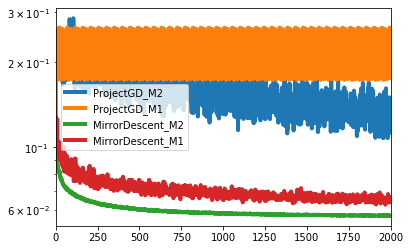

In [41]:
df_query = pd.DataFrame({"ProjectGD_M2":GD_M2_query, "ProjectGD_M1": GD_M1_query, "MirrorDescent_M2":MD_M2_query, "MirrorDescent_M1":MD_M1_query})
ax = df_query.plot.line(linewidth = 4, logy=True)
None

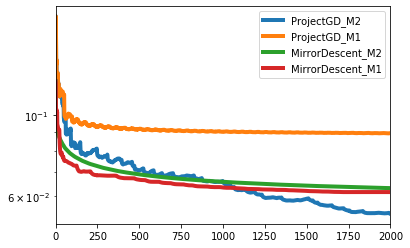

In [42]:
df_ave = pd.DataFrame({"ProjectGD_M2":GD_M2_ave, "ProjectGD_M1": GD_M1_ave, "MirrorDescent_M2":MD_M2_ave, "MirrorDescent_M1":MD_M1_ave})
ax = df_ave.plot.line(linewidth = 4, logy=True)
None

In [43]:
M = M2
K=2000

In [44]:
w.shape

(200,)

In [45]:
z

array([[-1, -1,  1, ...,  1, -1,  1],
       [ 1, -1, -1, ...,  1,  1, -1],
       [-1,  1,  1, ..., -1,  1,  1],
       ...,
       [ 1, -1,  1, ..., -1, -1,  1],
       [ 1, -1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ..., -1,  1,  1]])

# 2

In [46]:
p=10
n=200
B = np.random.randn(p,n)
b = np.ones(p)
f = lambda x: 1/2*(B.dot(x) - b).dot(B.dot(x) - b)
GD = lambda x: B.T.dot(B.dot(x) - b)
p,n = B.shape

In [47]:
#### Conditional GD(Frank-Wolfe):
def ConGD(B,b,N):
    p,n = B.shape
    x0 = np.zeros(n); x0[0] = 1
    x_old = x0
    x = [x0]
    A = 0
    value = [f(x0)]
    for i in range(N):
        ai = i/2+1
        A += ai
        f_GD = GD(x_old)
        
        tau = np.argmax(abs(f_GD))
        ebasis = np.zeros(n)
        ebasis[tau] = 1
        v = - np.sign(f_GD[tau]) * ebasis
        x_new = (A-ai)/A*x_old + ai/A*v
        
        x.append(x_new)
        value.append(f(x_new))
        x_old = x_new
        if (f(x_new)/value[0]) <= 10**(-1):
            sparse_out = x_new
        else:
            sparse_out = None
        
    return x_new, value, sparse_out

In [48]:
np.count_nonzero(np.array([0,2,3]))

2

In [49]:
ratio_total_CGD = 0

for i in range(30):
    x,val,sparse_out = ConGD(B,b,300)
    ratio = [va/val[0] for va in val]
    ratio_total_CGD += np.array(ratio)


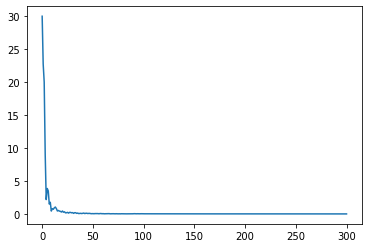

In [50]:
import matplotlib.pyplot as plt 
plt.plot(ratio_total_CGD)

In [51]:
w = np.linalg.eigvalsh(B.T.dot(B))
eta = 1/np.max(w)

In [52]:
#### Projected GD:
def ProGD(B,b,N,eta):  #   eta is the stepsize
    p,n = B.shape
    x0 = np.zeros(n); x0[0] = 1
    x_old = x0
    x = [x0]
    A = 0
    value = [f(x0)]
    for i in range(N):
        
        f_GD = GD(x_old)
        
        x_new = x_old - eta*f_GD
        x_new = euclidean_proj_l1ball(x_new,s = 1)
        
        x.append(x_new)
        value.append(f(x_new))
        x_old = x_new
        if (f(x_new)/value[0]) <= 10**(-1):
            sparse_out = x_new
        else:
            sparse_out = None
        
    return x_new, value, sparse_out

In [53]:
ratio_total_PGD = 0
nonzero = 0
for i in range(30):
    x,val,sparse_out = ProGD(B,b,300,eta)
    ratio = [va/val[0] for va in val]
    ratio_total_PGD += np.array(ratio)
    nonzero += np.count_nonzero(sparse_out)
    
ratio_total_PGD /= 30
nonzero /= 30

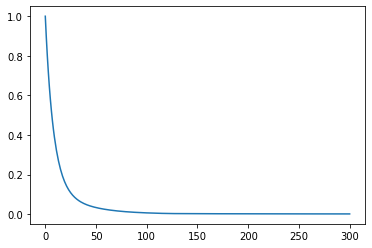

In [54]:
import matplotlib.pyplot as plt 
plt.plot(ratio_total_PGD)

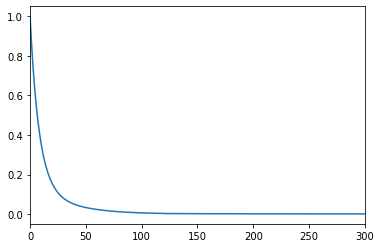

In [55]:
pd.Series(ratio_total_PGD).plot.line()

In [56]:
p=2
n=4
B = np.random.randn(p,n)

In [57]:
w,v = np.linalg.eig(B.T.dot(B))
w

array([ 3.58801059e+00,  1.79939715e+00,  8.48473482e-17, -1.01455345e-16])

# 3

In [58]:
n = 200
M = np.diag(v = 2*np.ones(n), k = 0) + np.diag(v = -np.ones(n-1), k = 1) + np.diag(v = -np.ones(n-1), k = -1)
b = np.zeros(n)
b[0] = 1
f = lambda x: 1/2*M.dot(x).dot(x) - b.dot(x)
def GD_oracle(x,eps):
    return x.dot(M) - b + eps*np.random.randn(n)
def minimum():
    x = np.linalg.inv(M).dot(b)
    return x, f(x)
_,f_star = minimum()

In [59]:
f_star

-0.4975124378109453

In [60]:
w,v = np.linalg.eig(M)

In [61]:
np.max(w)

3.999755713881303

In [66]:
#### Nesterov:
def AGD(N,eps):
    x0 = np.zeros(n)
    alpha = 1/4
    y0 = x0 - alpha*GD_oracle(x0,eps)
    v0 = y0
    value = [f(x0)]
    x_old = x0
    y_old = y0
    v_old = v0
    for i in np.arange(1,N+1):
        a = np.arange(1,i+1/2,1/2)
        A = a.sum()
        
        x_new = (A-a[-1])/A*y_old + a[-1]/A*v_old
        G = GD_oracle(x_new,eps)
        y_new = x_new - alpha*G
        v_new = v_old - a[-1]*alpha*G
        
        value.append(f(y_new))
        x_old = x_new; y_old = y_new; v_old = v_new

    return y_new, value


def SD(N,eps):    # steepest descent
    x0 = np.zeros(n)
    x_old = x0
    alpha = 1/4
    value = [f(x0)]
    for i in range(N):
        x_new = x_old - alpha*GD_oracle(x_old,eps)
        value.append(f(x_new))
        x_old = x_new
        
    return x_new, value

def SGD(N,eps):
    x = [np.zeros(n)]
    a = [0]
    i = 1
    x_old = x[-1]
    value = [f(x_old)]
    
    while i <= N:
        ai = 1/4/(i**(1/2))
        a.append(ai)
        
        x_new = x_old - ai*GD_oracle(x_old,eps)
        x.append(x_new)
        x_old = x_new
        x_outk = sum([a_item*x_item for a_item,x_item in zip(a,x)])/sum(a)
        value.append(f(x_outk))
        i += 1
        
    x_out = sum([i*j for i,j in zip(a,x)])/sum(a)
    return x_out, value



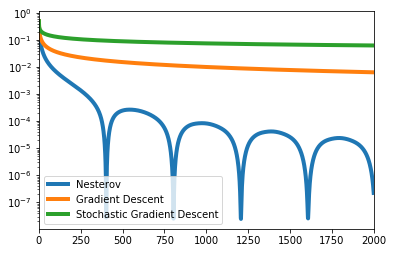

In [74]:
_,value_AGD = AGD(2000,10**(-5))
_,value_SD = SD(2000,10**(-5))
_,value_SGD = SGD(2000,10**(-5))

df = pd.DataFrame({"Nesterov":np.array(value_AGD)-f_star, "Gradient Descent": np.array(value_SD) -f_star, "Stochastic Gradient Descent": np.array(value_SGD)-f_star})
ax = df.plot.line(linewidth = 4, logy = True)
#ax.set_yticks([10**(-16),10**(-5),0.2])
None

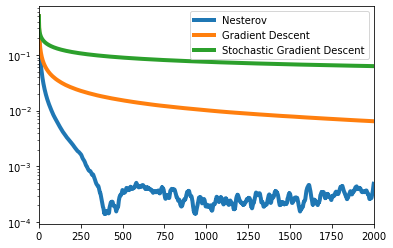

In [73]:
_,value_AGD = AGD(2000,10**(-3))
_,value_SD = SD(2000,10**(-3))
_,value_SGD = SGD(2000,10**(-3))

df = pd.DataFrame({"Nesterov":np.array(value_AGD)-f_star, "Gradient Descent": np.array(value_SD) -f_star, "Stochastic Gradient Descent": np.array(value_SGD)-f_star})
ax = df.plot.line(linewidth = 4, logy = True)
#ax.set_yticks([10**(-16),10**(-5),0.2])
None

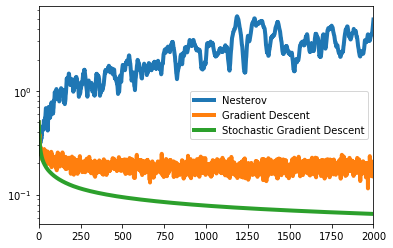

In [72]:
_,value_AGD = AGD(2000,10**(-1))
_,value_SD = SD(2000,10**(-1))
_,value_SGD = SGD(2000,10**(-1))

df = pd.DataFrame({"Nesterov":np.array(value_AGD)-f_star, "Gradient Descent": np.array(value_SD) -f_star, "Stochastic Gradient Descent": np.array(value_SGD)-f_star})
ax = df.plot.line(linewidth = 4, logy = True)
#ax.set_yticks([10**(-16),10**(-5),0.2])
None

As we can see, when epsilon is 10^(-3) or 10^(-5), the Nesterov's is the fastest, GD is slightly better than SGD. When we add more noise on the gradient, the Nesterov has more fluctuations and updates even worse than the initial value. The gradient descent also have more fluctuations and larger error. The SGD outperforms the other two methods in accuracy and stability.